In [144]:
# load in data

import pickle
import sys
import time 

def tic():
    return time.time()

def toc(tstart, nm=""):
    print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
    d = []
    with open(fname, 'rb') as f:
        if sys.version_info[0] < 3:
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='latin1')  # need for python 3
    return d

dataset="1"
cfile = "cam/cam" + dataset + ".p"
ifile = "imu/imuRaw" + dataset + ".p"
vfile = "vicon/viconRot" + dataset + ".p"

ts = tic()
camd = read_data(cfile)
imud = read_data(ifile)
calibrateSensor(imud)
vicd = read_data(vfile)
toc(ts,"Data import")

Data import took: 9.42183709145 sec.



In [50]:
# Sensor Calibration

def calibrateSensor(imud):
    import numpy as np
    sensitivity_gyro = 3.33*180/np.pi
    sensitivity_acc = 300

    gyro_scale = 3300/1023/sensitivity_gyro
    acc_scale = 3300/1023/sensitivity_acc


    # calculate the bias for imu data
    BIAS_SAMPLE = 100

    bias = np.mean(imud['vals'][:,:BIAS_SAMPLE], axis = 1)

    imud['vals'] = imud['vals'] - bias.reshape(6,1)

    # scale acc and gyro data
    imud['vals'][:3,:] = imud['vals'][:3,:]*acc_scale
    imud['vals'][3:,:] = imud['vals'][3:,:]*gyro_scale

    # flip Ax and Ay
    imud['vals'][:2,:] = -1*imud['vals'][:2,:]

    # Swap WzWxWy to WxWyWz
    temp = imud['vals'][3,:].copy()
    imud['vals'][3,:] = imud['vals'][4,:]
    imud['vals'][4,:] = imud['vals'][5,:]
    imud['vals'][5,:] = temp

    return True

In [145]:
# Import library for conversion functions
from transformations import *
# euler_from_matrix, euler_matrix, quaternion_from_euler, euler_from_quaternion, quaternion_matrix

# Quaternion functions

import numpy as np

def vector2hatmap(w):
    return np.array([[0, -w[2], w[1]],[w[2], 0, -w[0]],[-w[1], w[0], 0]])

def hatmap2vector(W):
    """
    param W: 3x3 hat map
    return: vector constructed from the hat map, numpy 1D-array
    """
    assert W.shape == (3,3)
    return np.array(W[2,1],W[0,2],W[1,0])

def Rot2Quat(w):
    zeta = w/np.linalg.norm(w)
    theta = np.linalg.norm(w)
    
    return np.append(np.cos(theta/2),np.sin(theta/2)*zeta)

def Quat2Rot(q):
    theta = 2*np.arccos(q[0])
    
    if theta:
        return theta*q[1:]/np.sin(theta/2)
    else:
        return np.zeros(len(q)-1)
    
def Quat_Conj(q):
    return np.append(q[0],-q[1:])

def Quat_Multiply(q,p):
    qs = q[0]
    ps = p[0]
    qv = q[1:]
    pv = p[1:]
    return np.append(qs*ps - np.dot(qv.T,pv), qs*pv + ps*qv + np.cross(qv,pv))

def Quat_MultiplyTwo(q,p):
    p0 = p[0]*q[0] - p[1]*q[1] - p[2]*q[2] - p[3]*q[3]
    p1 = p[0]*q[1] + p[1]*q[0] - p[2]*q[3] + p[3]*q[2]
    p2 = p[0]*q[2] + p[1]*q[3] + p[2]*q[0] - p[3]*q[1]
    p3 = p[0]*q[3] - p[1]*q[2] + p[2]*q[1] + p[3]*q[0]
    
    return np.array([p0,p1,p2,p3])

def Quat_Inv(q):
    return Quat_Conj(q)/(np.linalg.norm(q)**2)

def Quat_exp(q):
    
    qs = q[0]
    qv = q[1:]

    tol = 1e-17
    qv_n = np.linalg.norm(q[1:])
    if qv_n > tol:
        return np.exp(qs)*np.append(np.cos(qv_n), np.sin(qv_n)*qv/qv_n)
    else:
        return np.exp(qs)*np.append(np.cos(qv_n), np.sin(qv_n)*qv)

def Quat_log(q):
    
    qs = q[0]
    qv = q[1:]
    qv_n = np.linalg.norm(q[1:])
    q_n = np.linalg.norm(q)
    tol = 1e-17
    if qv_n < tol:
        return np.array([np.log(q_n),0,0,0])
    return np.append(np.log(q_n), qv*np.arccos(qs/q_n)/qv_n)

def Quat_Avg(q_set, weights):
    weights = np.array(weights).reshape(len(weights),1)
    q_avg = q_set[0]
    epsilon = 1e-6
    
    for i in range(1000):
        
        q_avg_inv = Quat_Inv(q_avg)
        q_e_set = np.array([Quat_Multiply(q_avg_inv,q_i) for q_i in q_set])

        ev_i = np.array([2*Quat_log(q_e)[1:] for q_e in q_e_set])

        ev_i = np.array([ev*(-np.pi+np.mod(np.linalg.norm(ev)+np.pi,2*np.pi))/(np.linalg.norm(ev)) if np.linalg.norm(ev) > epsilon else ev*(-np.pi+np.mod(np.linalg.norm(ev)+np.pi,2*np.pi)) for ev in ev_i])
        
        ev = np.sum(ev_i*weights,axis=0)

        q_avg = Quat_Multiply(q_avg,Quat_exp(np.append(0,ev/2)))
    
        if np.linalg.norm(ev) < epsilon:
            return q_avg
        
    return q_avg

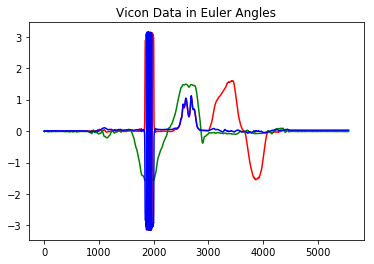

In [45]:
# Plotting Vicon Data

import matplotlib.pyplot as plt
from transformations import euler_from_matrix
# convert Vicon data from R matrix to Euler Angles
vicd['rots'].shape

euler_set = []
for i in range(vicd['rots'].shape[2]):
    rot_mat = vicd['rots'][:,:,i]
    euler_set.append(euler_from_matrix(rot_mat))
euler_set = np.array(euler_set)

roll_set = euler_set[:,0]
yaw_set = euler_set[:,1]
pitch_set = euler_set[:,2]

# plot the euler angles

plt.plot(roll_set, color = 'r')
plt.plot(yaw_set, color = 'g')
plt.plot(pitch_set, color = 'b')
plt.title('Vicon Data in Euler Angles')
plt.show()

In [140]:
# Simple Integration
def simpleIntegration(imud):
    from transformations import euler_from_quaternion, quaternion_matrix
    # initialize q_0
    q_t = np.array([1,0,0,0])

    i = 0
    euler_set = [euler_from_quaternion(q_t)]
    for w in imud['vals'][3:].T:
        if i == imud['vals'][3:].shape[1]-1:
            break
        delta_t = imud['ts'][0,i+1] - imud['ts'][0,i]
        q_t = Quat_Multiply(q_t,Quat_exp(np.append(0,0.5*w*delta_t)))
        euler_set.append(euler_from_quaternion(q_t))
        i += 1
    
    return euler_set

# UKT Prediction Function

def UKF_Euler_Prediction(imu_dict):
    """
    param imu_dict: dictionary that stores the imu data 'vals' and 'data'
    
    return: numpy array that stores the euler angles predicted by the filter
    """
    
    # initialization
    x_k = np.array([1,0,0,0,0,0,0])#.reshape(7,1)

    n = 6
    P_k = 0.0001*np.eye(n)
    Q = 0.0001*np.eye(n)
    R = 0.0001*np.eye(n)
    euler_from_state_vec = []
    g = np.array([0,0,0,1])

    count = 0
    for measurement in imu_dict['vals'].T:

        if count == imu_dict['vals'][3:].shape[1]-1:
            break

        # Sum the state conv and pre-process noise and cholesky decomp.
        S_k = np.linalg.cholesky(P_k + Q)
        Wi = np.hstack((np.sqrt(n)*S_k, -np.sqrt(n)*S_k))

        # create sigma points Xi_k from Wi_k and S_k and x_k

        # get quaternions from first 3 elements of Wi
        q_Wi = np.array([Quat_exp(np.append(0,0.5*r)) for r in Wi[:3,:].T])

        # get the quaternion part of the sigma points
        Xi_q_k = np.array([Quat_Multiply(x_k[:4],q) for q in q_Wi])

        # get the angular velocity part of the sigma points
        Xi_w_k = np.array([x_k[4:] + W for W in Wi[3:,:].T])

        # stack the two parts of the sigma points
        Xi_k = np.hstack((Xi_q_k, Xi_w_k))

        # add the mean to the sigma points
        Xi_k = np.vstack((x_k,Xi_k))

        # apply process model to sigma points
        # NOTE that noise is not applied in the process model, since noise is applied before process model

        delta_t = imu_dict['ts'][0,count+1] - imu_dict['ts'][0,count]

        # with delta_q for each sigma point
        Yi_q_k = np.array([Quat_Multiply(X[:4],Quat_exp(np.append(0,0.5*delta_t*X[4:]))) for X in Xi_k])

        Yi_w_k = Xi_k[:,4:]

        # compute the mean of a priori estimate 
        x_q_k_priori = Quat_Avg(Yi_q_k, np.append(0,np.ones(2*n)/(2*n)))

        #print np.linalg.norm(x_q_k_priori)
        x_w_k_priori = np.mean(Yi_w_k[1:],axis=0)

        #Yi_k = np.hstack((Yi_q_k,Xi_k[:,4:]))

        Wi_prime_q = np.array([Quat_Multiply(Quat_Inv(x_q_k_priori),q) for q in Yi_q_k]) # subtract quaternion mean by multiplication

        Wi_prime_w = Yi_w_k - x_w_k_priori # subtract angular velocity mean

        # compute the rotation vector variance from quaternion 
        Wi_prime_rot = np.array([ 2*Quat_log(q)[1:] for q in Wi_prime_q])

        # combine the variance Wi from rot and w
        Wi_prime = np.hstack((Wi_prime_rot,Wi_prime_w))

        # compute the covariance of Yi
        P_k_priori = np.dot(Wi_prime.T, Wi_prime)/(2*n+1)  #cov with equal weights 2*n+1

        # construct a new set of sigma points for measurement model

        # cholesky decomp. on the priori covariance
        S_Y_k = np.linalg.cholesky(P_k_priori)
        Wi_m = np.hstack((np.sqrt(n)*S_Y_k, -np.sqrt(n)*S_Y_k))

        # create sigma points Yi_m_k from Wi_m and mean 

        # get quaternions from first 3 elements of Wi
        q_Wi_m = np.array([Quat_exp(np.append(0,0.5*r)) for r in Wi_m[:3,:].T])

        # get the quaternion part of the new sigma points
        Yi_q_m_k = np.array([Quat_Multiply(x_q_k_priori,q) for q in q_Wi_m])

        # get the angular velocity part of the new sigma points
        Yi_w_m_k = np.array([x_w_k_priori + W for W in Wi_m[3:,:].T])

        # add the mean to the sigma points
        Yi_q_m_k = np.vstack((x_q_k_priori,Yi_q_m_k))
        Yi_w_m_k = np.vstack((x_w_k_priori,Yi_w_m_k))

        # project g in world frame to g' with Yi quaternion sigma points
        g_prime = np.array([Quat_Multiply(Quat_Inv(Y),Quat_Multiply(g,Y)) for Y in Yi_q_m_k]) #new sigma points

        # construct the measurement sigma points with g_prime and Yi_w_k
        Zi_k = np.hstack((g_prime[:,1:],Yi_w_m_k)) # new sigma points

        # compute mean from the Zi sigma points
        Z_k_mean = np.mean(Zi_k[1:],axis=0)

        # subtract sigma points Zi from Z_k mean
        W_z = Zi_k - Z_k_mean.reshape(1,6)

        P_zz = np.dot(W_z.T, W_z)/(2*n+1) # equal weights for all sigma points

        # compute covariance of innovation v
        P_vv = P_zz + R

        # compute the cross correlation matrix of X and Z
        P_xz = np.dot(Wi_prime.T, W_z)/(2*n+1)

        # compute Kalman Gain
        K_k = np.dot(P_xz,np.linalg.inv(P_vv))

        # get innovation from the difference between estimated measurements and actual measurements
        v_k = measurement - Z_k_mean

        # update the state vector mean with Kalman gain
        x_q_k = Quat_Multiply(x_q_k_priori,Quat_exp(np.append(0,0.5*np.dot(K_k,v_k)[:3])))
        x_w_k = x_w_k_priori + np.dot(K_k,v_k)[3:]
        x_k = np.append(x_q_k,x_w_k)

        # update the state vector covariance with Kalman gain
        P_k = P_k_priori - np.dot(np.dot(K_k,P_vv), K_k.T)

        euler_from_state_vec.append(euler_from_quaternion(x_k[:4]))

        #print count
        count += 1
        
    return np.array(euler_from_state_vec)

UKF on Training data set 1
UKF took: 23.2009749413 sec.



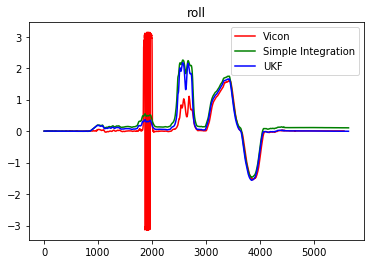

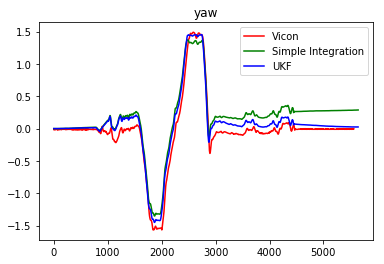

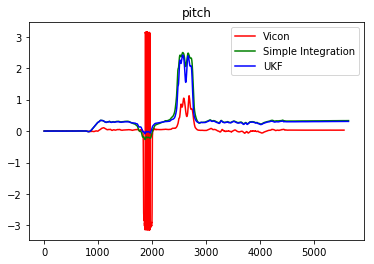

UKF on Training data set 2
UKF took: 20.1692488194 sec.



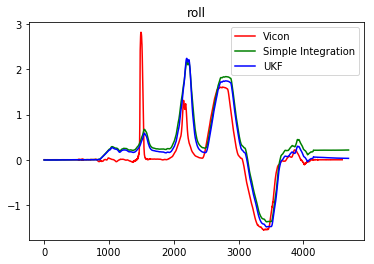

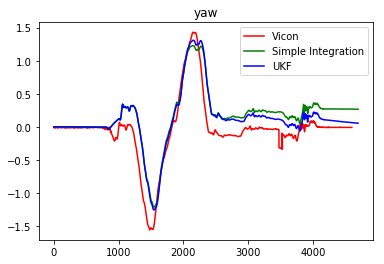

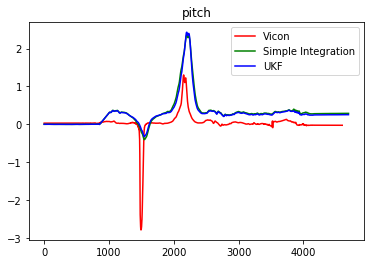

UKF on Training data set 3
UKF took: 14.8479850292 sec.



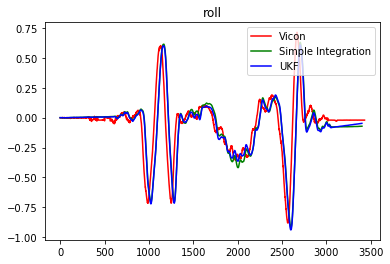

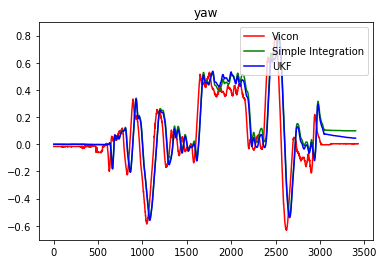

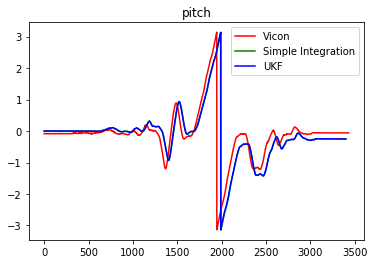

UKF on Training data set 4
UKF took: 13.0474438667 sec.



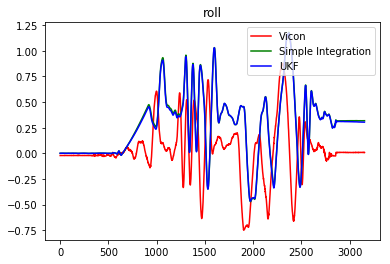

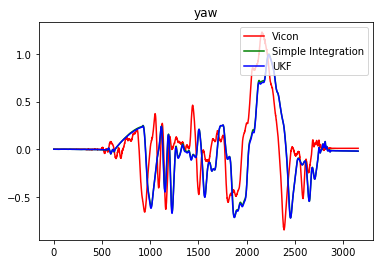

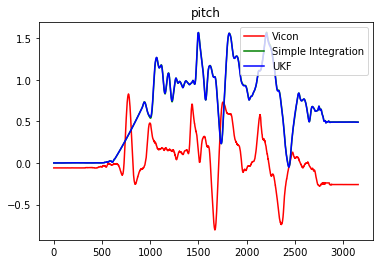

UKF on Training data set 5
UKF took: 13.1436078548 sec.



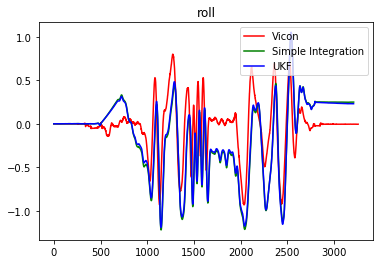

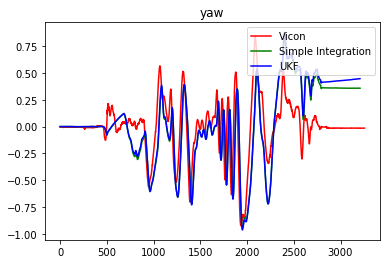

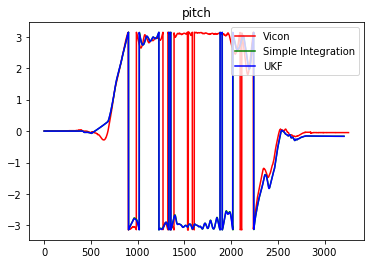

UKF on Training data set 6
UKF took: 13.7701330185 sec.



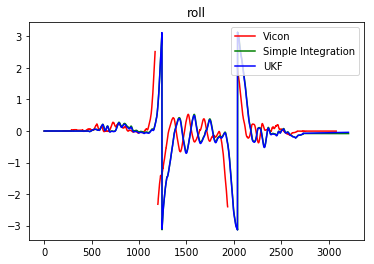

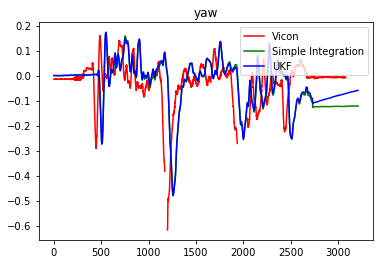

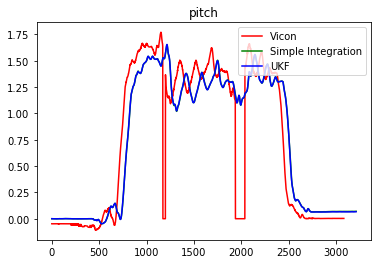

UKF on Training data set 7
UKF took: 14.9188170433 sec.



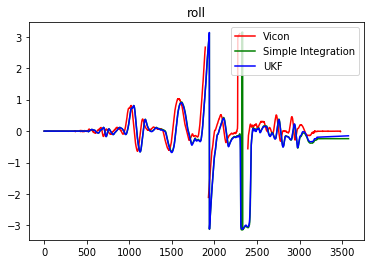

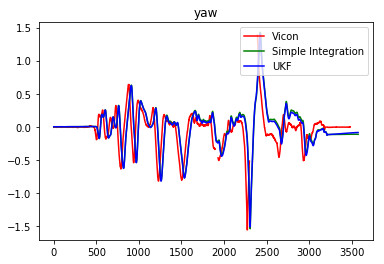

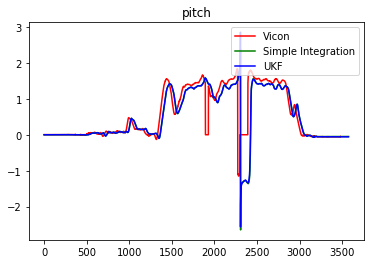

UKF on Training data set 8
UKF took: 15.0594608784 sec.



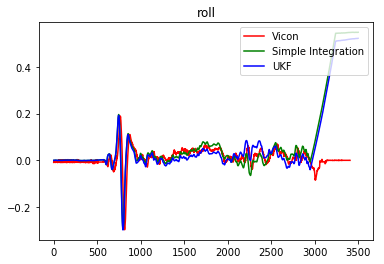

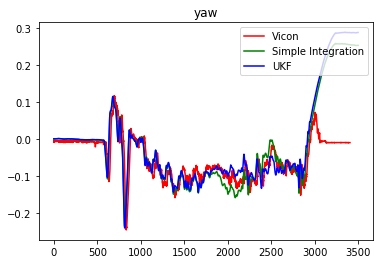

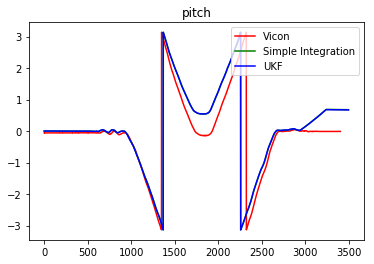

UKF on Training data set 9
UKF took: 13.2027199268 sec.



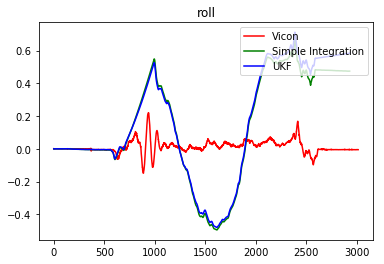

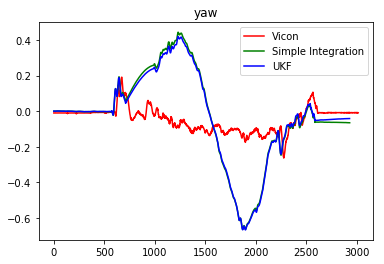

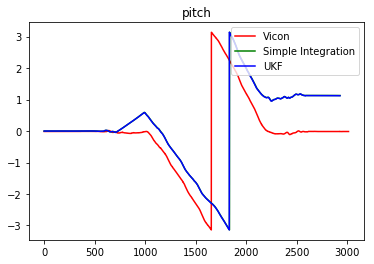

In [142]:
# Run and plot UKF, simple integration, Vicon data on all training sets

for num in range(1,10):

    ifile = "imu/imuRaw" + str(num) + ".p"
    vfile = "vicon/viconRot" + str(num) + ".p"
    
    imud = read_data(ifile)
    calibrateSensor(imud)
    vicd = read_data(vfile)

    print "UKF on Training data set " + str(num)
    
    ts = tic()
    euler_from_state_vec = UKF_Euler_Prediction(imud)
    toc(ts,"UKF")

    # convert Vicon data to Euler Angle
    euler_set = []
    for i in range(vicd['rots'].shape[2]):
        rot_mat = vicd['rots'][:,:,i]
        euler_set.append(euler_from_matrix(rot_mat))
    euler_set = np.array(euler_set)

    roll_set = euler_set[:,0]
    yaw_set = euler_set[:,1]
    pitch_set = euler_set[:,2]
    
    # Euler Angles from Simple Integration
    euler_set_simp = np.array(simpleIntegration(imud))
    
    roll_set_simp = euler_set_simp[:,0]
    yaw_set_simp = euler_set_simp[:,1]
    pitch_set_simp = euler_set_simp[:,2]
    
    roll_from_q_t_set = euler_from_state_vec[:,0]
    yaw_from_q_t_set = euler_from_state_vec[:,1]
    pitch_from_q_t_set = euler_from_state_vec[:,2]

    plt.plot(roll_set, color = 'r', label = 'Vicon')
    plt.plot(roll_set_simp, color = 'g', label = 'Simple Integration')
    plt.plot(roll_from_q_t_set, color = 'b', label = 'UKF')
    
    plt.title('roll')
    plt.legend(loc='upper right')
    plt.show()

    plt.plot(yaw_set, color = 'r', label = 'Vicon')
    plt.plot(yaw_set_simp, color = 'g', label = 'Simple Integration')
    plt.plot(yaw_from_q_t_set, color = 'b', label = 'UKF')
    plt.title('yaw')
    plt.legend(loc='upper right')
    plt.show()

    plt.plot(pitch_set, color = 'r', label = 'Vicon')
    plt.plot(pitch_set_simp, color = 'g', label = 'Simple Integration')
    plt.plot(pitch_from_q_t_set, color = 'b', label = 'UKF')
    plt.title('pitch')
    plt.legend(loc='upper right')
    plt.show()

In [132]:
# OPTIMIZED stitching
ts = tic()

import numpy as np

def latlon2cartesian(l): # conversion from Spherical to Cartesian
    """
    function was taken from:
    https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
    """
    
    r = l[0]
    lat = l[1]
    lon = l[2]
    
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    z = r * np.sin(lat)

    #return np.array([x, y, z])
    return [x, y, z]

def cartesian2latlon(c):
    """
    function was taken from:
    https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
    """
    
    x = c[0]
    y = c[1]
    z = c[2]
    
    #r = np.sqrt(x**2 + y**2 + z**2)
    r = 1
    lat = np.arcsin(z/r)
    lon = np.arctan2(y,x)

    #return np.array([r, lat, lon])
    return [r, lat, lon]


def construct_panorama(camd, vicd):

    # in pixels
    image_height = camd['cam'].shape[0]
    image_width = camd['cam'].shape[1]

    # number of pixels for height and width of panorama
    panorama_px_height = 180*image_height/45
    panorama_px_width = 360*image_width/60
    panorama = np.zeros((panorama_px_height,panorama_px_width,3))
    
    spher2px_ratio_ver = -1*panorama_px_height/np.pi
    spher2px_ratio_hor = -1*panorama_px_width/(2*np.pi)
    # cam_data = camd['cam'].reshape(camd['cam'].shape[0]*camd['cam'].shape[1],camd['cam'].shape[2],camd['cam'].shape[3]).copy()

    print "cam_data"
    print camd['cam'].shape

    FoV_hor = 60.0*np.pi/180 # rad
    FoV_ver = 45.0*np.pi/180  # rad

    px2spher_ratio_ver = float(FoV_ver)/image_height
    px2spher_ratio_hor = float(FoV_hor)/image_width

    # be careful with this, we are using 0,0 at top left corner of image instead of the center of the image

    # contruct pixel grid
    px_grid = np.zeros((image_height,image_width,3))

    for i in range(image_height):
        for j in range(image_width):
            px_grid[i,j] = np.array([-1*(i - image_height/2), -1*(j - image_width/2),1])

    px_grid = px_grid.reshape(px_grid.shape[0]*px_grid.shape[1],3)


    # everything in one shot
    cart_grid = []
    for coord in px_grid:
        l = [1,coord[0]*px2spher_ratio_ver,coord[1]*px2spher_ratio_hor]
        c = latlon2cartesian(l)
        cart_grid.append(c)
    
    cart_grid = np.array(cart_grid)

    count = 0
    for i in range(camd['cam'].shape[3]):
    #for i in range(380,1185):
        
        # find the closest ts
        timee = camd['ts'][0,i] # sample time ts for the image
        
        vicon_index = np.argmin(abs(vicd['ts'] - timee)) # find the index of vicon ts that is closest to camera ts
        
        rot_mat = vicd['rots'][:,:,vicon_index]
        # transform from camera frame to world frame

        # everything in one shot
        panorama_px = []

        for carti in cart_grid:
            #carti_world = Quat_Multiply(Quat_Multiply(Quat_Inv(q),Quat_exp(np.append(0,0.5*carti))),q)[1:]
            carti_world = np.dot(rot_mat,carti)
            latlon_w = cartesian2latlon(carti_world)
            panorama_px.append([latlon_w[1]*spher2px_ratio_ver + panorama_px_height/2, latlon_w[2]*spher2px_ratio_hor + panorama_px_width/2])
            
        panorama_px = np.array(panorama_px)

        # put the 1-d panorama pixels back into the image shape
        panorama_px_pic = panorama_px.reshape(image_height, image_width,2)

        # loop thru the image and put the pixel values on the panorama
        for ii in range(image_height):
            for jj in range(image_width):
                
                indexx = panorama_px_pic[ii,jj]
                panorama[int(indexx[0]), int(indexx[1]), :] = camd['cam'][ii,jj,:,i]

        count += 1
    print "count: " + str(count)
    return panorama

Training data set 2
cam_data
(240, 320, 3, 1259)
count: 1259
stitching took: 546.689419985 sec.



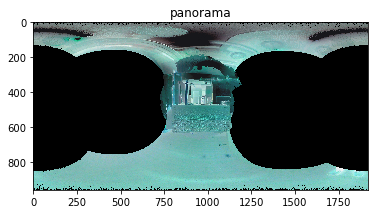

Training data set 8
cam_data
(240, 320, 3, 948)
count: 948
stitching took: 403.201730013 sec.



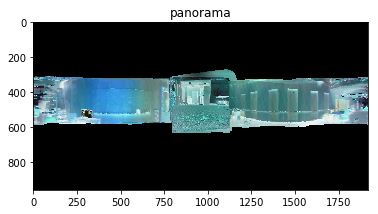

Training data set 9
cam_data
(240, 320, 3, 860)
count: 860
stitching took: 366.455765009 sec.



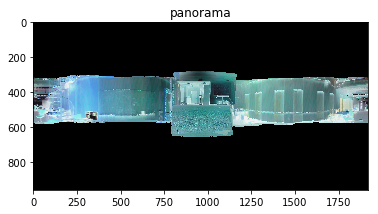

In [137]:
# Run stitching on all training sets with Vicon
import matplotlib.pyplot as plt

for num in [1,2,8,9]:
    
    # training set directory
    #ifile = "imu/imuRaw" + str(num) + ".p"
    cfile = "cam/cam" + str(num) + ".p"
    vfile = "vicon/viconRot" + str(num) + ".p"
    vicd = read_data(vfile)
    camd = read_data(cfile)

    print "Training data set " + str(num)
    
    # stitching
    ts = tic()
    panorama = construct_panorama(camd, vicd)
    toc(ts,"stitching")
    
    plt.imshow(panorama)
    plt.title("panorama")
    plt.show()
    
    import cv2
    cv2.imwrite('panorama' + str(num) + '.png', panorama)